# FordA Challenge Datasets

Description:

This data was originally used in a competition in the IEEE World Congress on Computational Intelligence, 2008. The classification problem is to diagnose whether a certain symptom exists or does not exist in an automotive subsystem. Each case consists of 500 measurements of engine noise and a classification. There are two separate problems: For FordB the training data were collected in typical operating conditions, but the test data samples were collected under noisy conditions.

Dataset source: 
* http://timeseriesclassification.com/description.php?Dataset=FordA
* http://timeseriesclassification.com/description.php?Dataset=FordB
* http://home.comcast.net/~nn_classification/ (dead link)

## Data preparation

In [7]:
import os
import glob
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sktime.datatypes import convert_to
from sktime.datasets import load_from_tsfile
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from mcfly.modelgen import generate_models
from mcfly.find_architecture import find_best_architecture
from mcfly.find_architecture import train_models_on_samples

warnings.filterwarnings('ignore')
%matplotlib inline
np.random.seed(42)
SEED=42

In [13]:
# Load train and test datasets
X_train, y_train = load_from_tsfile("../data/FordA/FordA_TRAIN.ts", return_y=True, return_data_type="numpy3D")

# Swap axes so that Mcfly models can consume the input data
X_train = np.swapaxes(X_train, 1, 2)

X_test, y_test = load_from_tsfile("../data/FordA/FordA_TEST.ts", return_y=True, return_data_type="numpy3D")
X_test = np.swapaxes(X_test, 1, 2)

# Encode labels using OneHotEncoder
ohe = OneHotEncoder()
ohe = ohe.fit(y_train.reshape(-1, 1))

y_train = ohe.transform(y_train.reshape(-1, 1)).toarray()
y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3601, 500, 1), (1320, 500, 1), (3601, 2), (1320, 2))

In [14]:
# Validation dataset
X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.20, 
    random_state=SEED,
    shuffle=True, 
    stratify=y_train
)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2880, 500, 1), (721, 500, 1), (2880, 2), (721, 2))

In [15]:
print("y_train:", Counter(np.argmax(y_train, axis=1)))
print("y_val:", Counter(np.argmax(y_val, axis=1)))
print("y_test:", Counter(np.argmax(y_test, axis=1)))

y_train: Counter({0: 1476, 1: 1404})
y_val: Counter({0: 370, 1: 351})
y_test: Counter({0: 681, 1: 639})


### Class weights

In [16]:
class_weights = compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(np.argmax(y_train, axis=1)),
    y = np.argmax(y_train, axis=1)                                                    
)

class_weights = dict(zip(np.unique(np.argmax(y_train, axis=1)), class_weights))
class_weights

{0: 0.975609756097561, 1: 1.0256410256410255}

### Model training

In [ ]:
%%time

file_name = f"model-comparison-20220811.json"
output_file = os.path.join("../data/mcfly-models-forda", file_name)
model_path = os.path.join("../data/mcfly-models-forda")

models = generate_models(
    X_train.shape, 
    y_train.shape[1],
    number_of_models=3,
    metrics=["accuracy"],
    model_types=['CNN', 'ResNet', 'InceptionTime'], #["InceptionTime"] #
)

history, val_metrics, val_losses = train_models_on_samples(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    models=models,
    nr_epochs=30,
    verbose=True,
    model_path=model_path,
    outputfile=output_file,
    subset_size=X_train.shape[0],
    class_weight=class_weights
)

In [24]:
best_model_index = np.argmax(val_metrics["accuracy"])
best_model, best_params, best_model_type = models[best_model_index]

print("Best model type:", best_model_type)

Best model type: ResNet


### Model training history plots

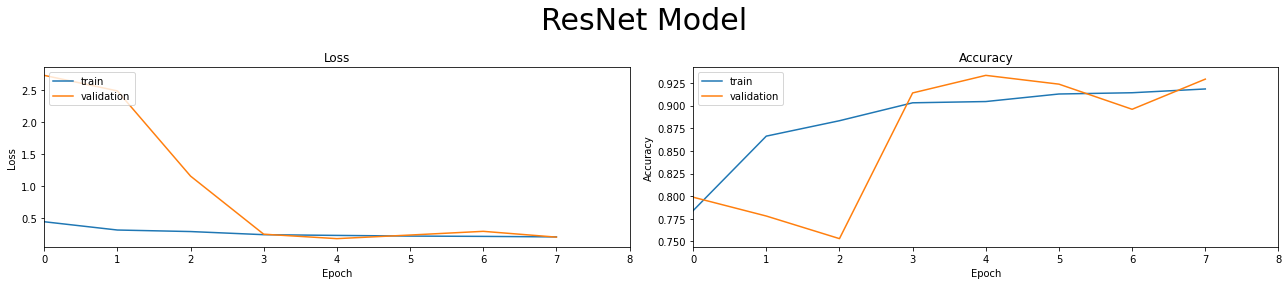

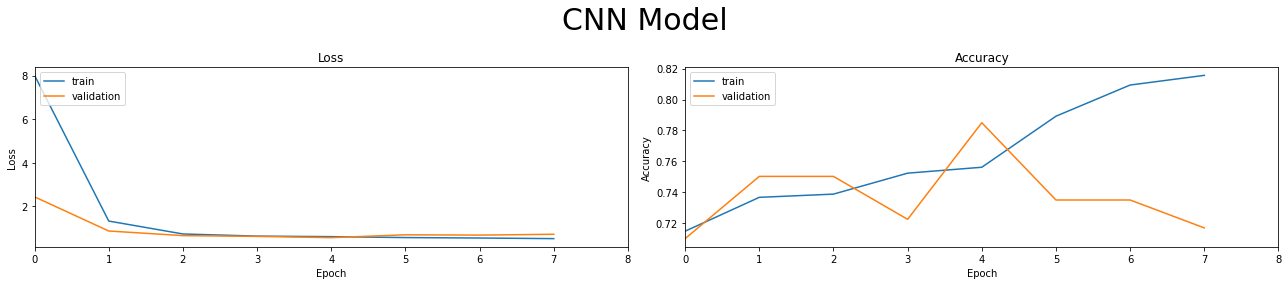

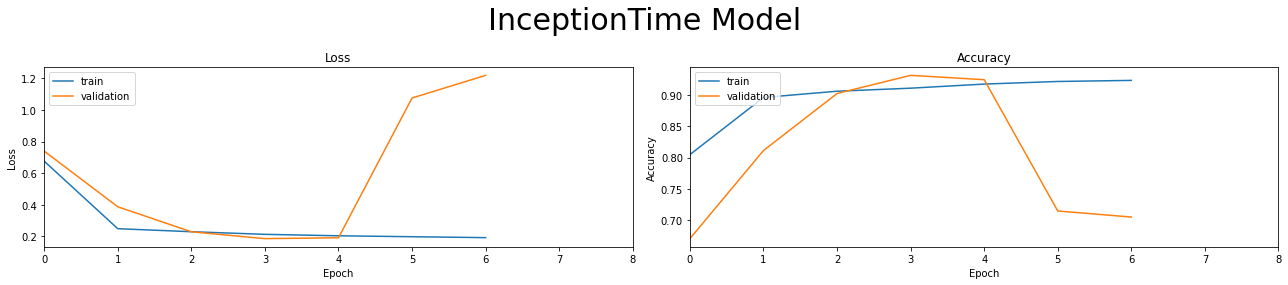

In [37]:
model_types = list(map(lambda m: m[2],models))

for i in range(len(model_types)):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 4))

    fig.suptitle(f"{model_types[i]} Model", fontsize=30)

    ax1.plot(history[i].history['loss'])
    ax1.plot(history[i].history['val_loss'])
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(['train', 'validation'], loc='upper left')
    ax1.set_xlim([0, 8])

    ax2.plot(history[i].history['accuracy'])
    ax2.plot(history[i].history['val_accuracy'])
    ax2.set_title('Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend(['train', 'validation'], loc='upper left')
    ax2.set_xlim([0, 8])

    plt.tight_layout()
    plt.show()

### ResNet model evaluation

In [38]:
%%time

y_pred = best_model.predict(X_test, batch_size=1)

1320/1320 [==============================] - 9s 6ms/step
CPU times: total: 9.08 s
Wall time: 9.41 s


In [39]:
print("Classification report for the ResNet model:\n")
print(classification_report(
    np.argmax(y_test, axis=1), 
    np.argmax(y_pred, axis=1)
))

Classification report for the ResNet model:

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       681
           1       0.94      0.93      0.93       639

    accuracy                           0.94      1320
   macro avg       0.94      0.94      0.94      1320
weighted avg       0.94      0.94      0.94      1320



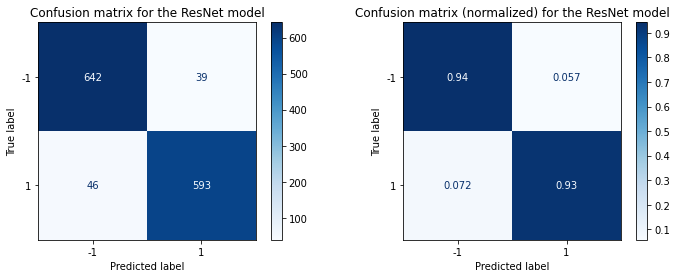

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test, axis=1), 
    np.argmax(y_pred, axis=1),
    display_labels=list(ohe.categories_[0]),
    normalize=None,
    cmap="Blues",
    ax=ax1
)
ax1.set_title("Confusion matrix for the ResNet model")

ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test, axis=1), 
    np.argmax(y_pred, axis=1),
    display_labels=list(ohe.categories_[0]),
    normalize="true",
    cmap="Blues",
    ax=ax2
)
ax2.set_title("Confusion matrix (normalized) for the ResNet model")

plt.show()